# Introduction -- Reminder

Each Python lab will start with a pre-flight exercise that walks through building some of the set up and tools ($\sim$ 30 min), followed by an in-class tutorial with time for Q+A (50 min) so you can walk through steps that will be necessary for the homework assignment you will submit ($\sim$ 3 hrs).  Each lab will contain starter code, similar to what you see below.  Please fill in the code to complete the pre-flight assignment in preparation for the in-class tutorial.  

Preflight ($\sim$30-60 min, 10 points) **Typically due: Wednesdays 3pm EST**

*Preflight typically graded by Wednesday 5p EST*

In-class tutorial and Q+A ($\sim$ 50 min, 10 points) **Typically occurs: Thursdays 9am EST**

Homework assignment ($\sim$ 3-5 hrs, 30 points) **Typically due: Mondays 9am EST** 

*Homework typically graded by Thursday 5p*

When we grade your homework, we will not run your code. Once submitted, your notebook should have the outputs for all of your results.  Please do not include long outputs from debugging, beyond a few print statements and the requested visualizations (i.e. plots).

**Grading:** When we grade your notebook, we will convert the .ipynb file to an HTML file.  We will be using [nbgrader](https://nbgrader.readthedocs.io/en/stable/) to grade your notebooks.  **Note:** If your ```IPython``` version is too old, we will *not* be able to grade your assignments.


# Phys 260 Python Preflight 9: Simple circuits with inductors  (10 points total)

## Preflight Summary
- Model of a circuit with R, L and C components

In this assignment we will examine the effect of inductors in circuits.  For the tutorial/hw, we will introduce the concept of alternating-current circuits. 

The canonical example of an inductor is a solenoid. When you run a current through a solenoid, it develops a magnetic field. If this current is changing, the magnetic field in the solenoid is changing too. And if that happens, the solenoid experiences a changing magnetic flux through itself. Faraday's law tells us that this will result in an emf in the solenoid that's in a direction to oppose the change in flux. 

The induced emf in the solenoid is proportional to the rate of change of the current, so we can write it as:
$$
    V_L = -L\frac{dI}{dt}.
$$
$L$ is a proportionality constant called the <b>inductance</b>. It's measured in Henries. 

Like capacitance, inductance is a geometrical quantity. We'll calculate it explicitly for a solenoid in class. Physically, inductors prevent currents from changing too quickly. If $dI/dt$ is large, the inductor will generate a large opposing emf that limits the current. Surge protectors are basically big inductors.

Inductors contribute to Kirchhoff's loop rule, just like resistors, capacitors, and batteries do. So we can solve circuits with inductors using techniques similar to what you did in the previous preflight.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Part 1 (10 points): A simple RL circuit

Consider this circuit:

<img src="http://www-personal.umich.edu/~gerdes/img/LR_DC.jpg">


### LaTeX the solution (4 points)
At $t=0$ the switch is closed.  Use LaTeX in the cell below to: 
- Write the loop rule (sum of voltage drops) for this circuit,
- Write the solution for the differential equation, $I(t)$, in terms of $V_{\rm batt}$, R, and L,
- Write the expression for the time constant, $\tau$,
- Write the voltage drop across the inductor as a function of time, $V_{L}$, in terms of $V_{\rm batt}$ and $\tau$.  Note, $V_{L}=-L\frac{dI}{dt}$.  This will be useful in modeling the current evolution.

The loop rule for this circuit reads:
$$
        V - IR -L\frac{dI}{dt} = 0.
$$
This is a first-order differential equation similar to what we encountered earlier for $RC$ circuits. The solution is
$$
        I(t) = \frac{V}{R}\left(1 - e^{-t/\tau}\right),
$$
where 
$$
        \tau = \frac{L}{R}
$$
is the time constant for the circuit (analogous to $RC$ from before). To get the inductor voltage as a function of time, apply the definition from above:
$$
    V_L = -L\frac{dI}{dt} = Ve^{-t/\tau}.
$$


### Create a class to model the RL circuit (2 points)

As a check, your LaTeX equations should show that the current starts at zero and exponentially approaches its asymptotic value of $V/R$ (as the inductor approaches the behavior of a wire).  The inductor voltage starts out at $V$ and exponentially decays to zero as the current becomes steady (no change in current means no voltage drop across the inductor).

In the cell below, create a class to model the RL circuit.  You may want to refer to the structure from the previous preflight.  Some differences include the fact that there is only one current, the initial current is zero (e.g. the `self.i_now`), and the characteristic timescale `self.tau` is different.

One recommendation in updating the now value step is to calculate the voltage drop across the inductor, given the current, then update the current 

In [11]:
class RLCircuit :
    def __init__(self,voltage_battery, resistance, inductance) :
        """
        Parameters
        ----------
        voltage_battery : float
            voltage across battery
        resistance : float
            value of resistance in ohms
        inductance : float 
            value of inductance in Henries
        """
        
        self.voltage_battery = voltage_battery
        self.resistance = resistance
        self.inductance = inductance
        
        # Use initial conditions to set the "now" values of the problem as attributes
        ### BEGIN SOLUTION
        self.tau = inductance / resistance
        self.i_now = 0
        self.voltage_L_now = voltage_battery
        ### END SOLUTION
        
        # Initialize the current, charge, and timesteps
        self.i_vals = []
        self.vl_vals = []
        self.timesteps = np.array([]) 
        
    def _set_now_vals(self) :
        """Calculate "now" current in terms of other attributes, setting attributes"""
        ### BEGIN SOLUTION
        voltage_R = self.i_now*self.resistance
        self.voltage_L_now = self.voltage_battery - voltage_R
        
        self.i_now += self.voltage_L_now/self.inductance * self.dt
        ### END SOLUTION
        
    def _set_timesteps(self, num_timescales, num_timesteps_per_timescale) :        
        """Internal method. Sets the attributes num_timesteps and dt.
        Parameters
        ----------
        num_timescales : floattimestep 
            number of timescales to evolve over
        num_timesteps_per_timescale : int
            number of timesteps per characteristic timescale, defines the time resolution 
        """
        
        self.dt = self.tau / num_timesteps_per_timescale
        print(self.dt)

        next_timesteps = np.arange(0, self.tau * num_timescales, self.dt)
        print('next_timesteps shape: ',next_timesteps.shape)
        try :
            last_timestep = self.timesteps[-1]
            next_timesteps += last_timestep
            self.timesteps = np.concatenate([self.timesteps, next_timesteps])
            
        except IndexError : 
            self.timesteps = next_timesteps        

    def evolve_circuit(self, num_timescales, num_timesteps_per_timescale) :
        """Evolve the spring, populate the acceleration, velocity and position (a_vals, v_vals, x_vals)
        Parameters
        ----------
        num_periods : float
            number of periods to evolve over
        num_timesteps_per_period : int
            number of timesteps per period, defines the time resolution         
        """
        
        self._set_timesteps(num_timescales, num_timesteps_per_timescale)

        # Time evolve the circuit using self._set_now_vals() and store values at each timestep
        ### BEGIN SOLUTION
        for timestep in np.arange(0, self.tau * num_timescales, self.dt) :
            # Populate i_vals and q_vals with current current and charge on capacitor
            self.i_vals.append(self.i_now)  
            self.vl_vals.append(self.voltage_L_now)
            # Update "now" values: q_now, and i_now (i_now can be updated with a method)
            self._set_now_vals()             
        ### END SOLUTION

In [12]:
"""Execute to check you're on the right track"""
test_rl = RLCircuit(10,1,1)
test_rl.evolve_circuit(5,100)
assert(test_rl.i_vals[0] < test_rl.i_vals[-1])

0.01
next_timesteps shape:  (500,)


### Create an instance and plot (2 points)
Create an instance of `RLCircuit` with the following components:
* V = 10 Volts
* R = 1 $\Omega$
* L = 1 H

Time evolve and plot:
* On the same axis: Voltage across the resistor vs. time (in units of $\tau$) and Voltage across the inductor vs. time.  Note, you may find it useful to store the voltage across the inductor at each timestep, but there are multiple ways to do this.
* On the same axis: Power delivered to the resistor vs. time and power delivered to the inductor vs. time (in units of $\tau$). Recall that $P = IV$. 

0.01
next_timesteps shape:  (500,)


Text(0.5, 0, 'Time [$\\tau=L/R$]')

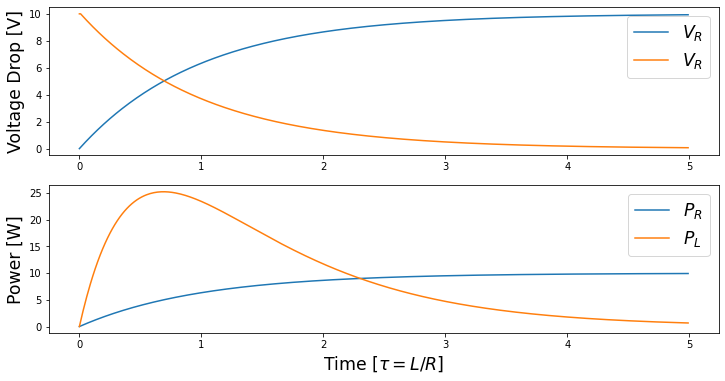

In [24]:
rl = RLCircuit(10,1,1)
rl.evolve_circuit(5,100)

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
# Plot voltage
ax1.plot(rl.timesteps/rl.tau, rl.i_vals * rl.resistance, label='$V_R$')
ax1.plot(rl.timesteps/rl.tau, rl.vl_vals, label='$V_R$')
ax1.set_ylabel('Voltage Drop [V]',fontsize='xx-large')
ax1.legend(fontsize='xx-large')
# Plot power
ax2.plot(rl.timesteps/rl.tau, np.array(rl.i_vals) * rl.resistance**2, label="$P_R$")
ax2.plot(rl.timesteps/rl.tau, np.array(rl.i_vals) * np.array(rl.vl_vals), label="$P_L$")
ax2.set_ylabel('Power [W]', fontsize='xx-large')
ax2.legend(fontsize='xx-large')
ax2.set_xlabel('Time [$\\tau=L/R$]', fontsize='xx-large')

### Open questions (2 points) :

<b>Answer</b> the following questions:
* At what time (in units of $\tau$) is the maximum power being delivered to the inductor? 
* What is the total energy $U$ delivered to the inductor? 
* If you change $L$ while holding $R$ constant, how does $U$ change? 
* If you change $R$ while holding $L$ constant, how does $U$ change?
* If you simultaneously double $R$ and $L$, you get a circuit with the same time constant as before. Is this new circuit equivalent to your original one?